In [1]:
import pandas as pd
import numpy as np
import glob
import os.path
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

### first step is to convert the two **txt** files into tables. the words file is loaded into the dataframe **dfword**, and the header file is loaded into the dataframe **df**.  Each of the txt header file has a few lines and each line contains two string. The first string in each line is column name and the second string is the label.

In [2]:
list_of_files=glob.glob('../dell_us_/tmp/*_.txt')
columns=['webpageID','og:type','salestype','country','language',]

df=pd.DataFrame(columns=columns,index=range(len(list_of_files)))

dfword=pd.DataFrame(columns=['webpageID','labels'],index=range(len(list_of_files)))

for i in range(len(list_of_files)):
    dfword.loc[i,'webpageID']=df.loc[i,'webpageID']=os.path.basename(list_of_files[i])[:7]
    word=open(list_of_files[i],'r').read().strip('\n')
    dfword.loc[i,'word']=word
    
    headerfile=list_of_files[i].split('.txt')[0]+'header.txt'
    try:
        f=pd.read_csv(headerfile,header=None,)
    except ValueError:
        continue
    listf=[f.loc[x,0].lower().split(' ') for x in range(f.shape[0])]
    #dicf={}
    #for j in listf:
     #   dicf[j[0]]=j[1]
    for j in listf:
        try:
            df.loc[i,j[0]]=j[1]
        except IndexError:
            continue

    
df.head()

webpageID   og:type                salestype country language  \
0   000003_  category  parent_product_category      us       en   
1   000004_  category         product_category      us       en   
2   000005_  document                      NaN     NaN       en   
3   000006_  category         product_category      us       en   
4   000007_  category         product_category      us       en   

          categorypath tooltip ui-tabs-panel  
0         all-products     NaN           NaN  
1             desktops     NaN           NaN  
2                  NaN     NaN           NaN  
3              laptops     NaN           NaN  
4  enterprise-products     NaN           NaN

 ### Further clean up the header table. put similar descriptions in *og:type* into one class. Creat `other-product` in `categorypath` for those unusual labels.

 ### We will use `categorypath` as the prelable for supervised learning. Plot the statistics of labels in  `categorypath` using `np.unique` and `np.argsort`.  

['all-products' 'cloud-client-computing' 'deals' 'dell-tablets' 'desktops'
 'document_' 'enterprise-products' 'laptops' 'other-product'
 'server-storage-solutions' 'software' 'unkowntype_']
number of labels is 12


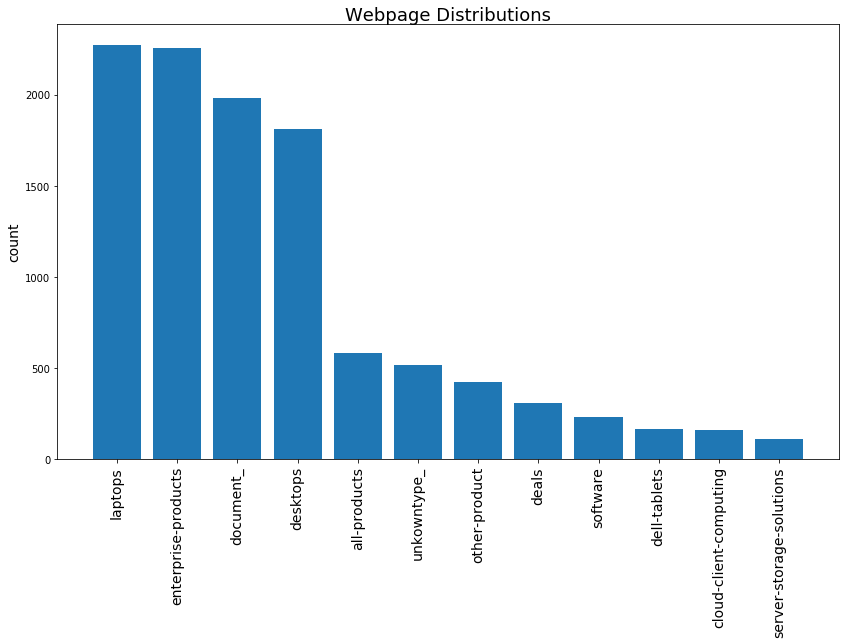

In [3]:
df=df.fillna(' ')
#df.loc[:,'og:type_cpath']=['_'.join((i,j))for i, j in zip(df.loc[:,'og:type'],df.loc[:,'categorypath'])]

#uniquelablef=df.loc[:,'og:type_cpath'].unique()
df.loc[df.loc[:,'og:type']=='document','categorypath']='document_'
df.loc[df.loc[:,'og:type']=='documentsearch','categorypath']='document_'
df.loc[df.loc[:,'og:type']==' ','categorypath']='unkowntype_'
#uniquelablef=df.loc[:,'categorypath'].unique()
for i in range(df.shape[0]):
    if df.loc[i,'categorypath'] not in {'document_','laptops','desktops',
                                        'enterprise-products','unkowntype_','deals','software','dell-tablets',
                                     'server-storage-solutions','cloud-client-computing','all-products'}:
           df.loc[i,'categorypath']='other-product'
    


#print(uniquelablef)
#print('number of labels is {}'.format(len(uniquelablef)))
fig=plt.figure(figsize=(14,8))
labels,labelscount = np.unique(df.loc[:,'categorypath'].values,return_counts=True)
print(labels)
print('number of labels is {}'.format(len(labels)))
indices=np.argsort(labelscount)[::-1]
plt.bar(range(len(labels)),labelscount[indices],align='center')
plt.xticks(range(len(labels)),labels[indices],rotation=90, fontsize=14)
plt.title('Webpage Distributions', fontsize=18)
plt.ylabel('count', fontsize=14)
plt.show()

#for i in range(len(uniquelablef)):
    #df.loc[df.loc[:,'og:type_cpath']==uniquelablef[i],'label']=i
    #df.loc[df.loc[:,'categorypath']==uniquelablef[i],'label'] = int(i)

#df

### start to process the text table, put `categorypath` column into the dfword as labels.  

In [4]:
dfword=dfword.fillna(' ')
dfword.loc[:,'labels']=df.loc[:,'categorypath']
allwords=dfword.loc[:,'word']
dfword.head()

webpageID               labels  \
0   000003_         all-products   
1   000004_             desktops   
2   000005_            document_   
3   000006_              laptops   
4   000007_  enterprise-products   

                                                word  
0   dell o sign in click to chat or call us shop ...  
1   for hours only get tremendous savings up to o...  
2   alternate sign in click to chat or call us lo...  
3   for hours only get tremendous savings up to o...  
4   dell o sign in click to chat or call us shop ...

### To get rid of useless words, use `stopwords` from `nltk.corpus` package.  To further clean up redundant words, one can use `PorterStemmer` from `nltk.stem.porter` . This function can convert plural to singular. 

###  Initialize `TfidfVectorizer` for getting the *bag of words*. `idf` is *inverse-document-frequency reweighting* , which is an advanced method to calculate the words impartance. in this case,  `use_idf` is the option to use it. In the code below it is set to `False`, because it didnt help that much to the final result. `max_features` is the number of words that will be counted.  

In [5]:


stops=stopwords.words("english")
stops.append('dell')
#stops=stops+['intel','inside','xeon','chat','terms','community',
#             'trademarks','legal','call','sale','privacy','statement','payment']

porter= PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

vectorizer = TfidfVectorizer(analyzer='word',stop_words=stops,use_idf=False,
                             tokenizer=None, norm=None, max_features= 500)




### the `fit_transform` will return the *bag of words*, and it is mandatory to use `toarray` to convert it to an array like structure. `get_feature_names` will return the key words.

In [6]:
words_features = vectorizer.fit_transform(allwords)
words_features = words_features.toarray().astype(int)

key_words = vectorizer.get_feature_names()


### The function `drop` and `join` is used to remove columns and combine two dataframe into a new one.  `dfword` is now a table contains the labels and all the key words frequency.

In [7]:
dfword=dfword.drop('word',axis=1)
dfword=dfword.join(pd.DataFrame(data=words_features,columns=key_words))
dfword.head()


webpageID               labels  ac  accepting  access  accessories  \
0   000003_         all-products   0          0       0            3   
1   000004_             desktops   0          0       2            0   
2   000005_            document_   0          0       6            0   
3   000006_              laptops   0          0       0            0   
4   000007_  enterprise-products   0          0       0            0   

   accidental  account  adapter  add ...   workspace  workstation  \
0           0        1        0    0 ...           0            1   
1           0        1        0    0 ...           1           10   
2           0        5        0    0 ...           0            0   
3           0        1        0    0 ...           0            3   
4           0        1        0    0 ...           0            0   

   workstations  world  www  wyse  xeon  xps  year  yes  
0             6      1    0     0     3    2     0    0  
1            11      1    0     0     5   17     0    0  
2             0      0    0     0     3    0     0    0  
3            11      6    0     0     4   23     0    0  
4             0      0    0     0     4    0     0    0  

[5 rows x 502 columns]

In [8]:
dfword.shape

(10834, 502)

In [9]:
#df.to_csv('featuretable.csv', index=False)
#dfword.to_csv('bagofwords.csv', index=False)
#newdf=pd.read_csv('featuretable.csv')
#newdf.head()

In [10]:
#df.to_csv('featuretable.txt', index=False)

#newdf=pd.read_csv('featuretable.txt')
#newdf.head()

### Plot the cumulative distribution of the interested key word. Again, `np.unique` is used to get the cumulative distribution.

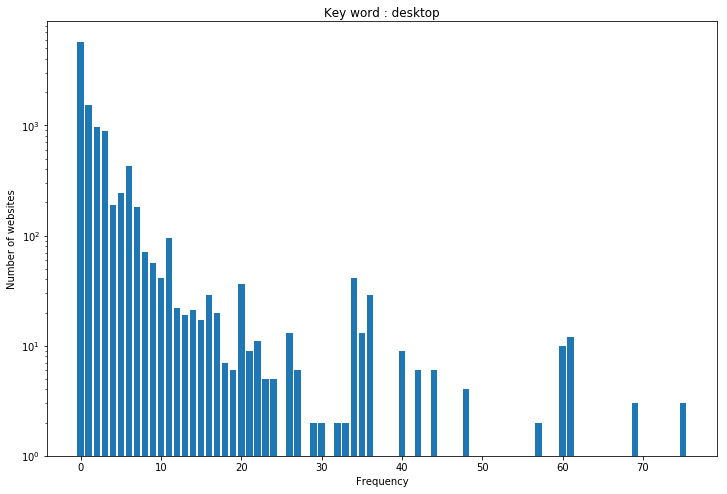

In [11]:
wordfrequency,infilerequency=np.unique(dfword.loc[:,'desktop'].values,return_counts=True)
plt.figure(figsize=(12,8))
plt.bar(wordfrequency,infilerequency,align='center')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Number of websites')
plt.title('Key word : desktop')
#plt.xlim(0,20)

In [12]:
def plot_cumulative_distribution(dataframe, keyword):
    wordfrequency,infilerequency=np.unique(dataframe.loc[:,keyword].values,return_counts=True)
    fig=plt.figure(figsize=(12,8))
    plt.bar(wordfrequency,infilerequency,align='center')
    plt.yscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Number of websites')
    plt.title('Key word : {}'.format(keyword))
    plt.show()
    fig.savefig('hendrik/highfrq/{}.png'.format(keyword))

### To plot the key words frequency in decending order, use `np.sum` and `np.argsort`, and plot with `plt.bar` . 

In [13]:
words_count=np.sum(dfword.iloc[:,2:],axis=0)
indices_wc=np.argsort(words_count)[::-1]
#for i in indices_wc[:20]:
#   plot_cumulative_distribution(dfword,dfword.columns[2:][i])
    


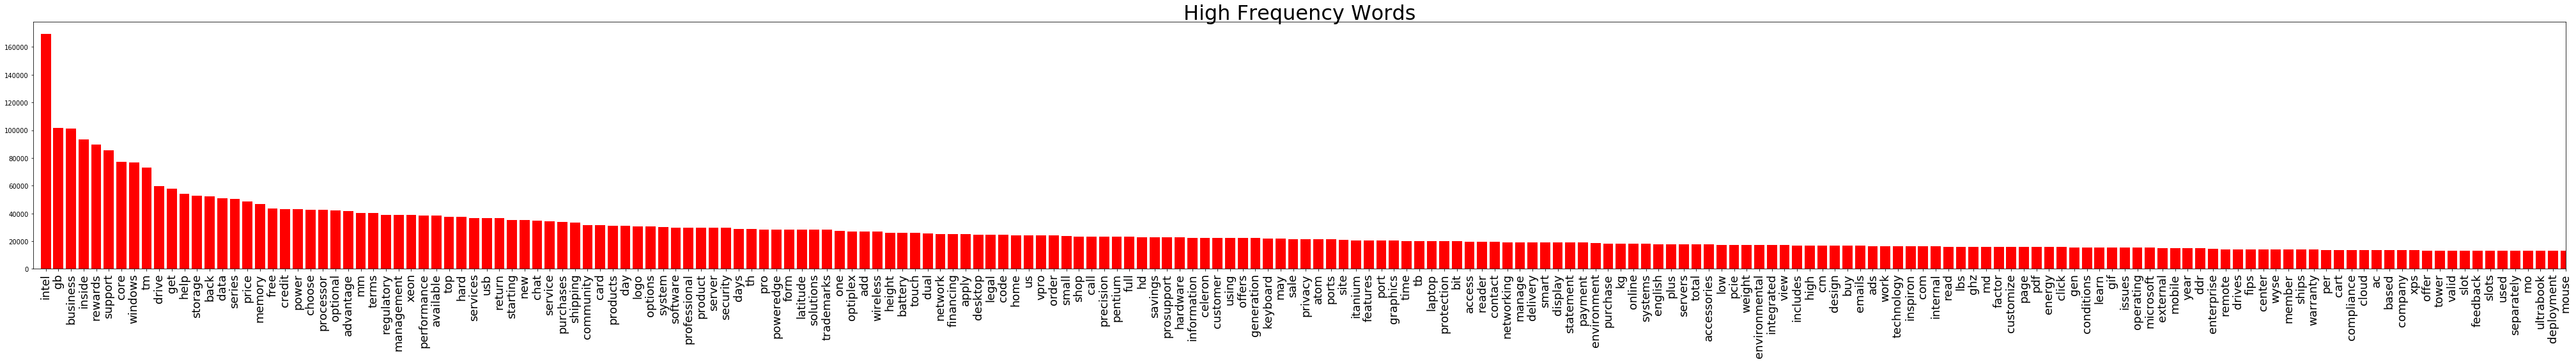

In [14]:
fig=plt.figure(figsize=(56,8))
plt.bar(range(len(words_count)),words_count[indices_wc],color='red',align='center')
plt.xticks(range(len(words_count)),np.array(dfword.columns[2:])[indices_wc],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,200)
plt.title('High Frequency Words', fontsize=32)
plt.show()

### calculate median and mean of the words count

In [16]:
words_median = np.median(dfword.iloc[:,2:]+2,axis=0).astype(float)
#words_median[words_median==0]=0.01

words_mean = np.mean(dfword.iloc[:,2:]+2,axis=0)
median_over_mean = words_median/words_mean
print(words_median)
print(words_mean)
print(median_over_mean)

[  2.    2.    3.    2.    2.    2.    2.    2.    2.    4.    2.    6.
   3.    2.    2.    2.    2.    2.5   3.    2.    3.    4.    2.    4.
   4.    2.    3.    2.    2.    2.    2.    2.    2.    2.    3.    2.
   3.    2.    2.    6.    2.    2.    4.    2.    2.    3.    2.    4.
   2.    2.    2.    2.    3.    2.    6.    3.    2.    3.    2.    3.
   2.    2.    3.    3.    5.    3.    3.    2.    2.    2.    2.    3.
   2.    2.    2.    2.    3.    3.    2.    2.    2.    5.    3.    3.
   2.    2.    3.    3.    5.    3.    3.    3.    2.    2.    2.    4.
   2.    3.    3.    4.    2.    2.    2.    2.    2.    2.    2.    2.
   2.    2.    2.    2.    2.    2.    2.    2.    2.    3.    2.    2.
   2.    2.    2.    2.    2.    2.    2.    2.    2.    2.    2.    3.
   3.    4.    2.    3.    2.    2.    2.    3.    2.    2.    2.    2.
   2.    2.    2.    2.    2.    2.    3.    3.    2.    2.    3.    2.
   3.    2.    3.    2.    2.    2.    3.    2.    3.    3.    3

### Plot the `median_over_mean` with the key word frequency decending order. I dont quite understand how to set individual axes, that is why i use `plt.xticks`. 

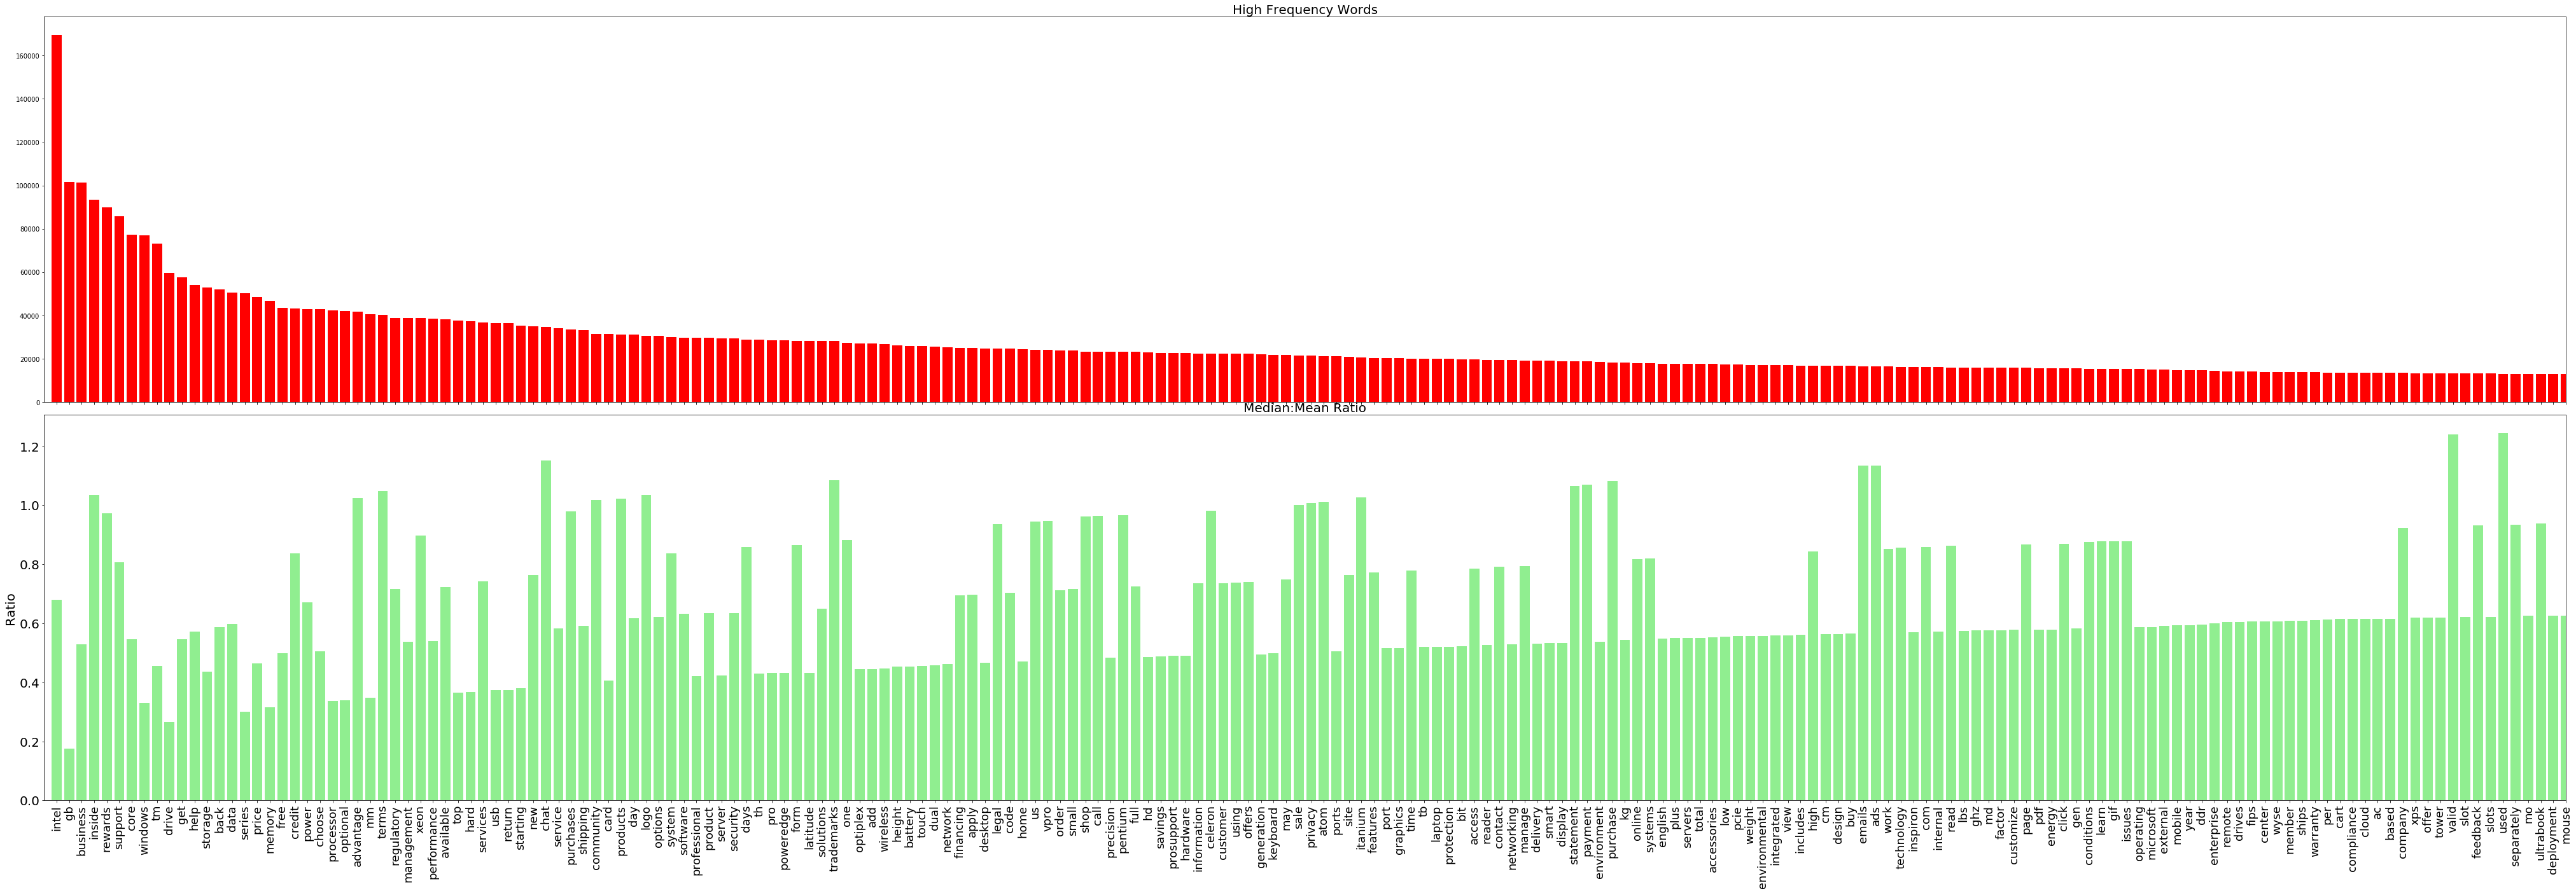

In [17]:
fig,axes=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(56,20))
axes[1].bar(range(len(words_count)),median_over_mean[indices_wc],color='lightgreen',align='center')
axes[0].bar(range(len(words_count)),words_count[indices_wc],color='red',align='center')
axes[0].set_title('High Frequency Words', fontsize=20)
plt.xticks(range(len(words_count)),np.array(dfword.columns[2:])[indices_wc],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,200)
axes[1].set_title('Median:Mean Ratio', fontsize=20)
axes[1].set_ylabel('Ratio',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### plot the median over mean in log scale. 

In [18]:
words_median_log = np.median(np.log(dfword.iloc[:,2:]+2),axis=0).astype(float)
#words_median[words_median==0]=0.01

words_mean_log = np.mean(np.log(dfword.iloc[:,2:]+2),axis=0)
median_over_mean_log = words_median_log/words_mean_log
print(words_median_log)
print(words_mean_log)
print(median_over_mean_log)

[ 0.69314718  0.69314718  1.09861229  0.69314718  0.69314718  0.69314718
  0.69314718  0.69314718  0.69314718  1.38629436  0.69314718  1.79175947
  1.09861229  0.69314718  0.69314718  0.69314718  0.69314718  0.89587973
  1.09861229  0.69314718  1.09861229  1.38629436  0.69314718  1.38629436
  1.38629436  0.69314718  1.09861229  0.69314718  0.69314718  0.69314718
  0.69314718  0.69314718  0.69314718  0.69314718  1.09861229  0.69314718
  1.09861229  0.69314718  0.69314718  1.79175947  0.69314718  0.69314718
  1.38629436  0.69314718  0.69314718  1.09861229  0.69314718  1.38629436
  0.69314718  0.69314718  0.69314718  0.69314718  1.09861229  0.69314718
  1.79175947  1.09861229  0.69314718  1.09861229  0.69314718  1.09861229
  0.69314718  0.69314718  1.09861229  1.09861229  1.60943791  1.09861229
  1.09861229  0.69314718  0.69314718  0.69314718  0.69314718  1.09861229
  0.69314718  0.69314718  0.69314718  0.69314718  1.09861229  1.09861229
  0.69314718  0.69314718  0.69314718  1.60943791  1

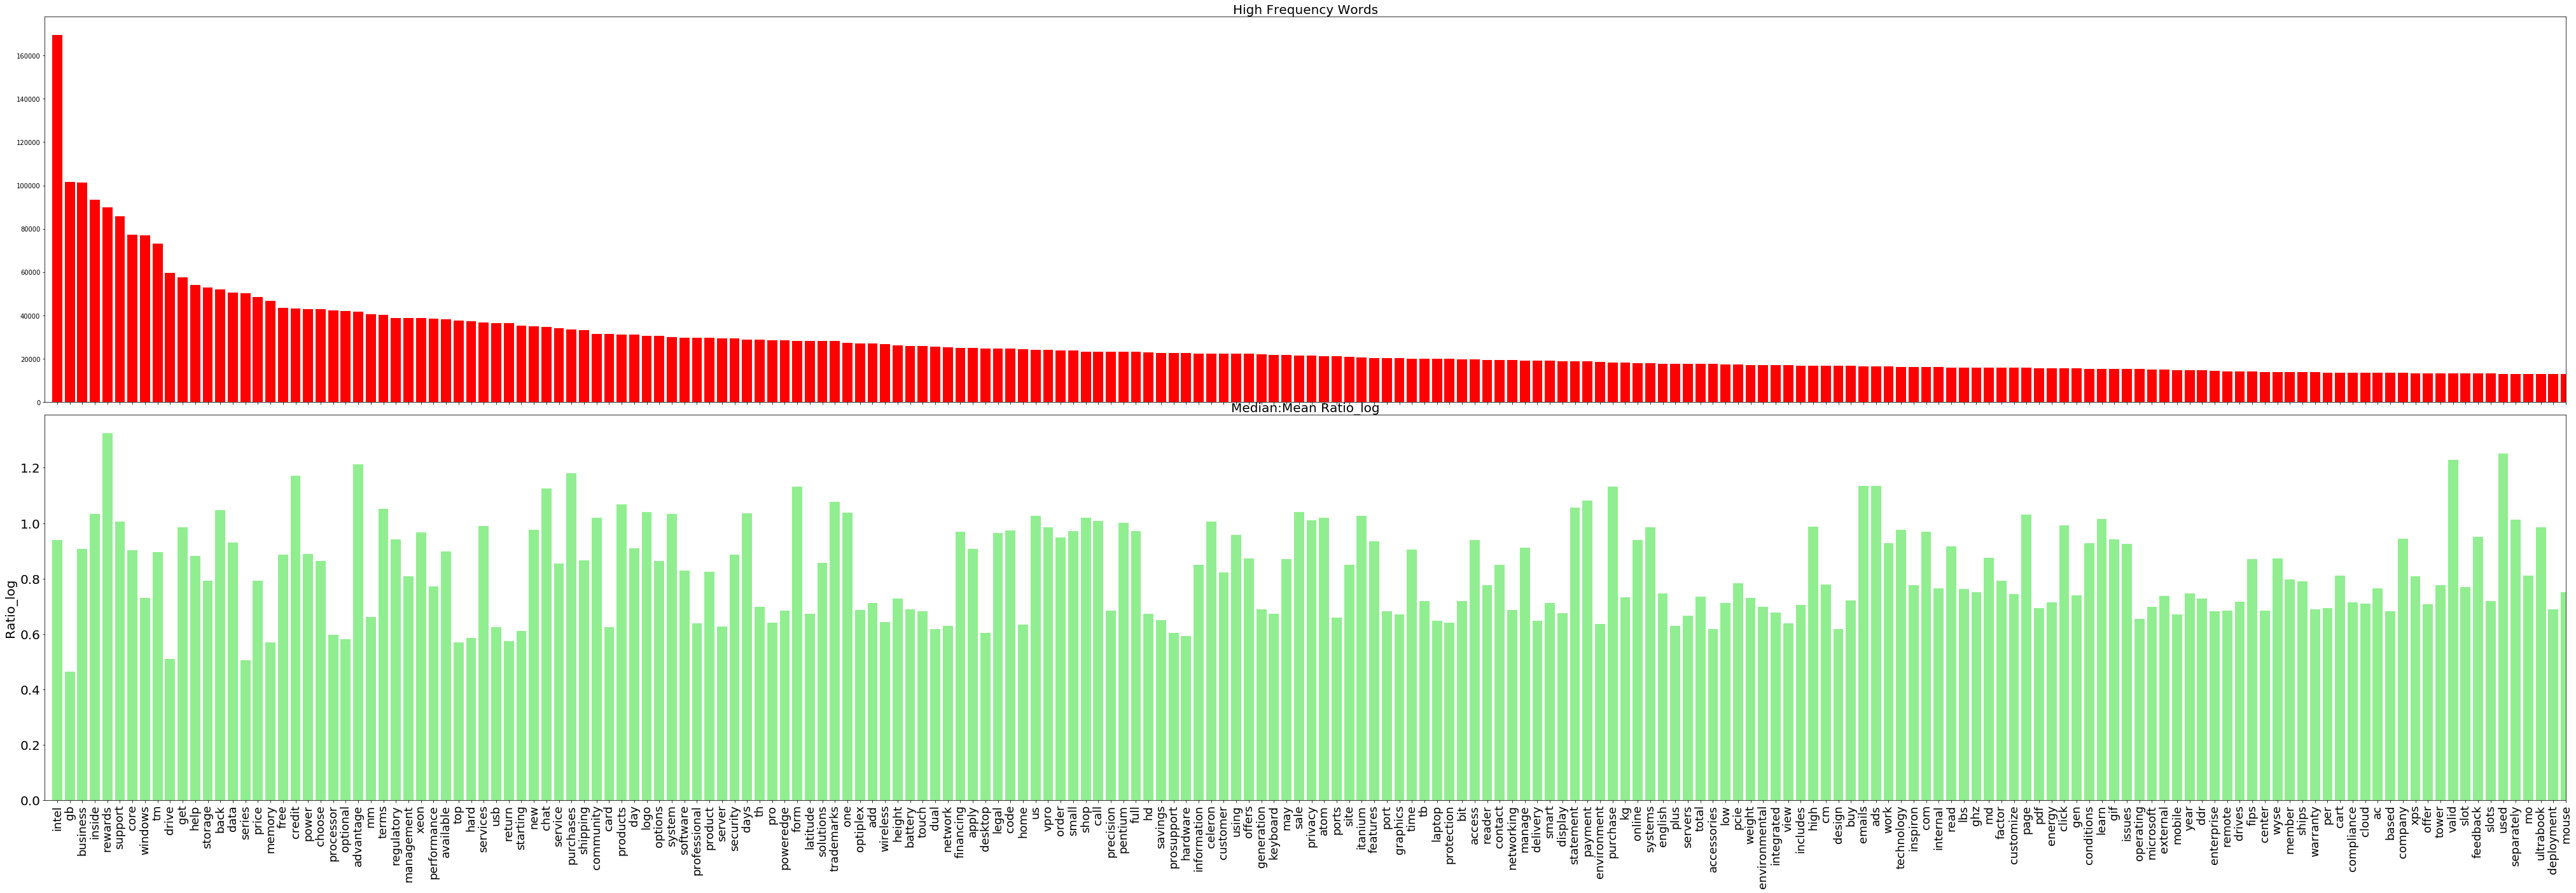

In [19]:
fig,axes=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(56,20))
axes[1].bar(range(len(words_count)),median_over_mean_log[indices_wc],color='lightgreen',align='center')
axes[0].bar(range(len(words_count)),words_count[indices_wc],color='red',align='center')
axes[0].set_title('High Frequency Words', fontsize=20)
plt.xticks(range(len(words_count)),np.array(dfword.columns[2:])[indices_wc],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,200)
axes[1].set_title('Median:Mean Ratio_log', fontsize=20)
axes[1].set_ylabel('Ratio_log',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Get rid of the key words by comparing the median_over_mean value larger than the average of the standard diviation. Save the indices which is going to be discarded.

In [20]:
mean_value_log_ratio= np.mean(median_over_mean_log)
mean_value_log_ratio_sd=np.std(median_over_mean_log)
words_to_remove=[]
to_remove_indices=[]
for i in range(len(words_count)):
    if median_over_mean_log[i] > mean_value_log_ratio+0.3*mean_value_log_ratio_sd:
        words_to_remove.append(dfword.columns[2:][i])
        to_remove_indices.append(i)

print(mean_value_log_ratio)
print(mean_value_log_ratio_sd)
print(words_to_remove)
print('total remove number is {}'.format(len(words_to_remove)))


0.852787632542322
0.1568263914893211
['access', 'ads', 'advantage', 'ajax', 'applied', 'apply', 'arrive', 'atom', 'back', 'balance', 'blog', 'bose', 'bt', 'business', 'call', 'careers', 'celeron', 'charges', 'chat', 'click', 'close', 'code', 'com', 'community', 'company', 'compare', 'conditions', 'contracts', 'core', 'corporate', 'corporation', 'countries', 'coupons', 'credit', 'cs', 'customers', 'data', 'date', 'day', 'days', 'discounts', 'eligible', 'email', 'emails', 'employee', 'engagement', 'events', 'except', 'expert', 'expires', 'extra', 'features', 'feedback', 'financing', 'find', 'form', 'forums', 'full', 'get', 'gif', 'greater', 'high', 'inc', 'inside', 'instead', 'intel', 'investors', 'issues', 'itanium', 'item', 'join', 'law', 'learn', 'legal', 'limited', 'live', 'loader', 'logo', 'loyalty', 'make', 'manage', 'map', 'match', 'medium', 'minimum', 'monthly', 'must', 'new', 'newsroom', 'offered', 'one', 'online', 'order', 'outlet', 'page', 'paid', 'partnerdirect', 'payment', '

### Assign value 0 to those discarded words, and plot again as the previous plot

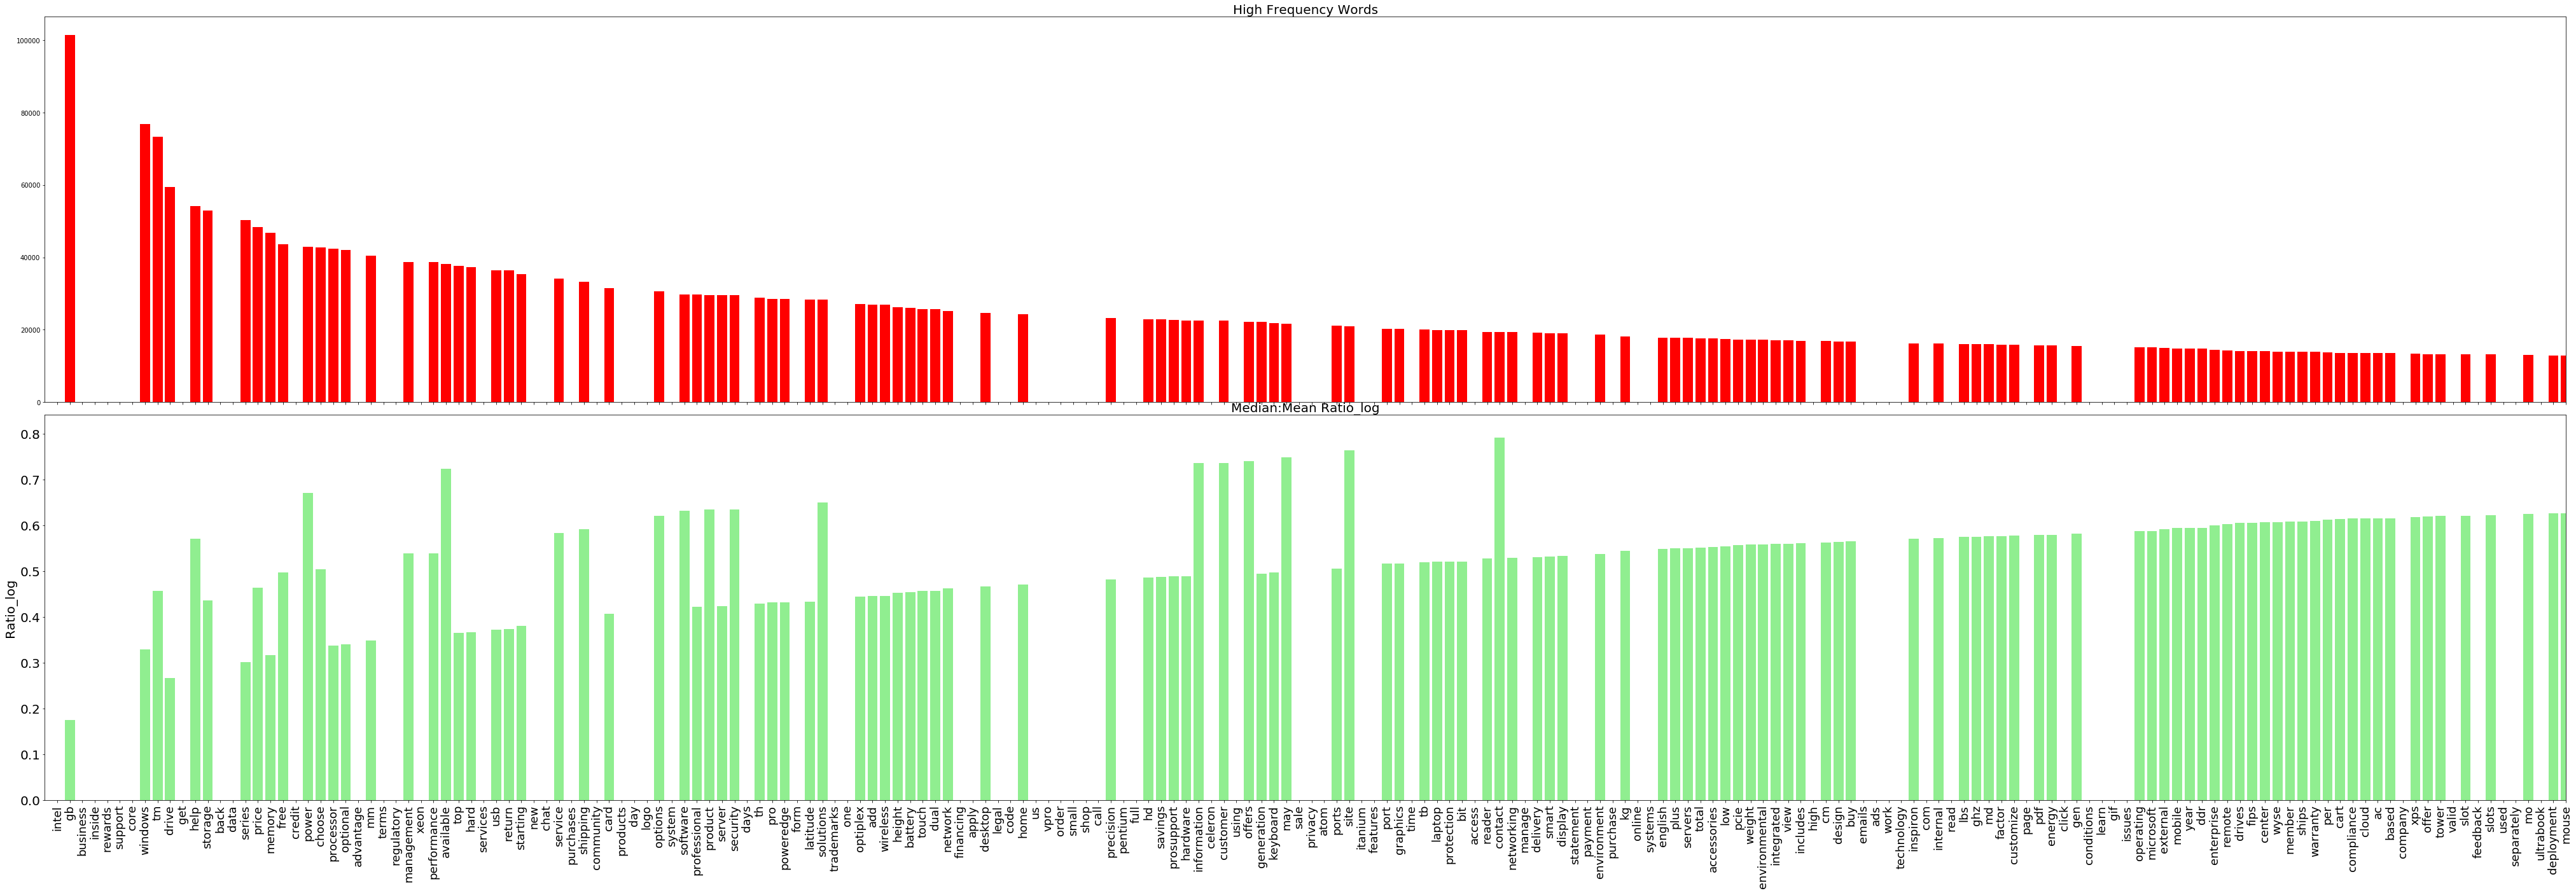

In [21]:
words_count[to_remove_indices]=0
median_over_mean[to_remove_indices]=0
#indices_wc_new=np.argsort[words_count][::-1]

fig,axes=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(56,20))
axes[1].bar(range(len(words_count)),median_over_mean[indices_wc],color='lightgreen',align='center')
axes[0].bar(range(len(words_count)),words_count[indices_wc],color='red',align='center')
axes[0].set_title('High Frequency Words', fontsize=20)
plt.xticks(range(len(words_count)),np.array(dfword.columns[2:])[indices_wc],rotation=90,fontsize=18)
plt.tight_layout()
plt.xlim(-1,200)
axes[1].set_title('Median:Mean Ratio_log', fontsize=20)
axes[1].set_ylabel('Ratio_log',fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [22]:
#dfword=dfword.drop(dfword.columns[2:][to_remove_indices],axis=1)
dfword.shape


(10834, 502)

### Save the first 200 key words for further use. 

In [23]:
dfword.iloc[:,:202].to_csv('bagofwords.csv',index=False)
df.to_csv('featuretable.csv',index=False)
#dfrm_words=pd.DataFrame(data=words_to_remove,columns=['words'])
#dfrm_words.to_csv('words_to_remove.csv',index=False)

In [24]:
#test=pd.read_csv('words_to_remove.csv')
#test

### Plot the correlation matrix, use `corr()`. The correlations of the top 50 high frequency words are calculated. Use `cm` from `matplotlib` which is a for the plotting color,  `fig.add_subplot(111)` 's details are [here] [http://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111]. `matshow` is to *Plot a matrix or an array as an image.*



In [41]:
from matplotlib import cm

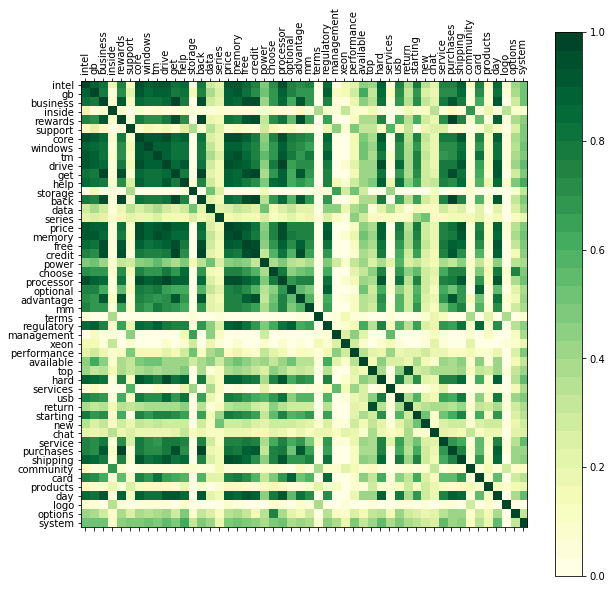

In [50]:
correlations=dfword.iloc[:,2+indices_wc[:50]].corr()
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
cmap=cm.get_cmap('YlGn',30)
cax=ax.matshow(correlations, vmin=0,vmax=1, cmap=cmap)
fig.colorbar(cax)
ax.set_xticks(range(0,50,1))
ax.set_yticks(range(0,50,1))

ax.set_xticklabels(dfword.columns[2:][indices_wc[:50]],rotation=90)
ax.set_yticklabels(dfword.columns[2:][indices_wc[:50]])
plt.show()

In [38]:
fig.add_subplot??

In [40]:
ax.matshow??

In [43]:
cm.get_cmap??